# MLP:
The first half of this notebook may be used to train an MLP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_batches, shuffle, train_val_split, preds_to_scores, scores_to_preds
from src.mlp import MLP
from src.rnn import RNN

%load_ext autoreload
%autoreload 2

In [3]:
# Define the path to the data. This is the training dataframe saved from the preprocessing notebook.
data_path = './data/train_df.pkl'
train_df = pd.read_pickle(data_path)

In [4]:
# To further isolate our data, we will only examine essays from a single set
# Feel free to experiment with different essay sets!

set = 1
df = train_df.loc[train_df['essay_set'] == set]
df.head()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score,essays_embed,word_count,min_score,max_score,rater1_domain1_norm,rater2_domain1_norm,norm_score
0,1,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",299,2.0,12.0,4,4,8
1,2,1,5,4,9,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",349,2.0,12.0,5,4,9
2,3,1,4,3,7,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",236,2.0,12.0,4,3,7
4,5,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",387,2.0,12.0,4,4,8
9,10,1,5,4,9,"[[0.15637, -0.40361, -0.29629, -0.34259, -0.18...",419,2.0,12.0,5,4,9


In [5]:
# We should get a plot here to examine score distribution for this set

# In order to avoid bias toward more common scores, we will limit the number
# of essays from each scoring bucket to a set value
score_df = None
min_score = int(df['min_score'].min())
max_score = int(df['max_score'].max())

n_max = 100
for i in range(min_score,max_score+1):
    if score_df is None:
        score_df = df.loc[df['domain1_score'] == i][:n_max]
    else:
        temp_df = df.loc[df['domain1_score'] == i][:n_max]
        score_df = pd.concat([score_df, temp_df])
df = score_df

In [6]:
# Extract essay vectors and corresponding scores
X = np.array(df['essays_embed'])
y = np.array(df['domain1_score'])
X = np.stack(X, axis=0)
print('There are {} training essays, each of shape {} x {}'.format(X.shape[0], X.shape[1], X.shape[2]))

There are 563 training essays, each of shape 426 x 200


These essays are the wrong shape to feed directly into the MLP. Therefore, each essay matrix needs to be flattened into a 1-D vector.

In [7]:
X_flatten = np.reshape(X, [X.shape[0], -1])
print('There are {} training essays, each a vector of length {}'.format(X_flatten.shape[0], X_flatten.shape[1]))

There are 563 training essays, each a vector of length 85200


The next step is to shuffle the data and separate it into training and validation sets.

In [8]:
X, y = shuffle(X_flatten, y)

X_train, y_train, X_val, y_val = train_val_split(X, y, train_prop=0.85)

Here we need to transform the labels to the form that the network will predict. For example, in set 1, the essays are graded on a scale from 2-12, therefore there are 11 classes into which the network will try to classify each essay. However, the network will classify essays into the scale 0-10. Therefore, this step will perform this shift on the labels. If the scoring range already starts at 0, no shift is performed.

In [9]:
if min_score != 0:
    y_train_adj = scores_to_preds(y_train, min_score)
    print('Training labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_train),max(y_train), min(y_train_adj), max(y_train_adj)))
    y_val_adj = scores_to_preds(y_val, min_score)
    print('Validation labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_val),max(y_val), min(y_val_adj), max(y_val_adj)))
else:
    print('No score adjustment necessary')
    y_train_adj = y_train
    y_val_adj = y_val

Training labels shifted from a scale of (2,12) to (0,10)
Validation labels shifted from a scale of (2,12) to (0,10)


Enter the name of the model you're training here. The model will be saved to the 'model/' directory of this project. Then choose other parameters such as learning rate, number of training epochs, l2 regularization, dropout probability, and regression vs classification. All other parameters are derived and do not need to be set manually.

In [10]:
# User Defined Parameters
model_name = 'mlp_set1'
hidden_dims = [1024,256]
weight_scale = 1e-2
batch_size = 16
n_epochs = 20
l2_reg = 1e-4
keep_prob = 0.8
reg = False
lr = 1e-4

# Derived Parameters
input_dim = X_train.shape[1]
num_classes = max_score-min_score + 1
n_batches = round(X_train.shape[0]/batch_size)
batch_gen = get_batches(X_train, y_train_adj, batch_size, net_type='mlp')

mlp_net = MLP(input_dim=input_dim, hidden_dims=hidden_dims, num_classes=num_classes, weight_scale=weight_scale,\
              l2_reg=l2_reg, keep_prob=keep_prob, regression=reg)

In [11]:
train_loss_hist, val_loss_hist = mlp_net.train(gen=batch_gen, X_val=X_val, y_val=y_val_adj, n_epochs=n_epochs, n_batches=n_batches, lr=lr,\
                                               save_every_n=5, model_name=model_name)



---------- Training epoch: 1 ----------
Epoch 1, Batch 1 -- Loss: 3.622 Validation accuracy: 0.202
Sample Grade Predictions: 
Preds:   8 7 7 7 7 7 7 8 7 8 7 7 7 8 7 7 7 8 7 7
Actual:  6 7 8 8 4 5 8 4 9 4 4 5 4 4 7 8 7 4 7 4
Best validation accuracy! - Saving Model


---------- Training epoch: 2 ----------
Epoch 2, Batch 1 -- Loss: 1.927 Validation accuracy: 0.190
Sample Grade Predictions: 
Preds:   7 7 6 7 7 8 7 8 8 7 7 8 7 8 7 7 7 7 8 8
Actual:  6 7 8 8 4 5 8 4 9 4 4 5 4 4 7 8 7 4 7 4


---------- Training epoch: 3 ----------
Epoch 3, Batch 1 -- Loss: 1.705 Validation accuracy: 0.238
Sample Grade Predictions: 
Preds:   7 7 6 7 6 6 7 5 7 6 5 6 5 6 6 7 6 6 7 6
Actual:  6 7 8 8 4 5 8 4 9 4 4 5 4 4 7 8 7 4 7 4
Best validation accuracy! - Saving Model


---------- Training epoch: 4 ----------
Epoch 4, Batch 1 -- Loss: 1.187 Validation accuracy: 0.440
Sample Grade Predictions: 
Preds:   6 7 6 8 5 5 8 5 6 4 5 5 4 5 5 8 6 5 8 8
Actual:  6 7 8 8 4 5 8 4 9 4 4 5 4 4 7 8 7 4 7 4
Best validatio

In [12]:
# Extract Loss data for plotting
x = []
train_loss = []
val_loss = []
for k,v in train_loss_hist.items():
    x.append(k[0]-1+k[1]/n_batches)
    train_loss.append(v)
    val_loss.append(val_loss_hist[k])

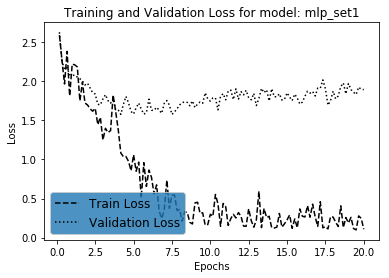

In [13]:
fig, ax = plt.subplots()
ax.plot(x, train_loss, 'k--', label='Train Loss')
ax.plot(x, val_loss, 'k:', label='Validation Loss')

legend = ax.legend(loc='lower left', shadow=False, fontsize='large')
legend.get_frame().set_facecolor('C0')
plt.title('Training and Validation Loss for model: '+model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
preds = mlp_net.predict('./model/'+model_name, X_val)

# We need to map predictions from classes in the model to actual scores
preds = preds_to_scores(preds, min_score=min_score)

INFO:tensorflow:Restoring parameters from ./model/mlp_set1


In [17]:
from src.preprocess import quadratic_weighted_kappa

k = quadratic_weighted_kappa(y_val, preds)

print('The quadratic weighted kappa score for set {} using {} is : {}'\
     .format(set, model_name, k))

The quadratic weighted kappa score for set 1 using mlp_set1 is : 0.7933755479785679


# RNN:
The second half of this notebook may be used for training an RNN - specifically an LSTM or GRU

In [47]:
# Define the path to the data
data_path = './data/train_df.pkl'
train_df = pd.read_pickle(data_path)

# To further isolate our data, we will only examine essays from a single set
# Feel free to experiment with different essay sets!
set = 1
df = train_df.loc[train_df['essay_set'] == set]
df.head()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score,essays_embed,word_count,min_score,max_score,rater1_domain1_norm,rater2_domain1_norm,norm_score
0,1,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",299,2.0,12.0,4,4,8
1,2,1,5,4,9,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",349,2.0,12.0,5,4,9
2,3,1,4,3,7,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",236,2.0,12.0,4,3,7
4,5,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",387,2.0,12.0,4,4,8
9,10,1,5,4,9,"[[0.15637, -0.40361, -0.29629, -0.34259, -0.18...",419,2.0,12.0,5,4,9


In [48]:
# In order to avoid bias toward more common scores, we will limit the number
# of essays from each scoring bucket to a set value
score_df = None
min_score = int(df['min_score'].min())
max_score = int(df['max_score'].max())

n_max = 100
for i in range(min_score,max_score+1):
    if score_df is None:
        score_df = df.loc[df['domain1_score'] == i][:n_max]
    else:
        temp_df = df.loc[df['domain1_score'] == i][:n_max]
        score_df = pd.concat([score_df, temp_df])
df = score_df

In [49]:
# Extract essay vectors and corresponding scores
X = np.array(df['essays_embed'])
y = np.array(df['domain1_score'])
X = np.stack(X, axis=0)
print('There are {} training essays, each of shape {} x {}'.format(X.shape[0], X.shape[1], X.shape[2]))

There are 563 training essays, each of shape 426 x 200


The next step is to shuffle the data and separate it into training and validation sets.

In [50]:
X, y = shuffle(X, y)
X_train, y_train, X_val, y_val = train_val_split(X, y, train_prop=0.85)

Here we need to transform the labels to the form that the network will predict. For example, in set 1, the essays are graded on a scale from 2-12, therefore there are 11 classes into which the network will try to classify each essay. However, the network will classify essays into the scale 0-10. Therefore, this step will perform this shift on the labels.

In [51]:
if min_score != 0:
    y_train_adj = scores_to_preds(y_train, min_score)
    print('Training labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_train),max(y_train), min(y_train_adj), max(y_train_adj)))
    y_val_adj = scores_to_preds(y_val, min_score)
    print('Validation labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_val),max(y_val), min(y_val_adj), max(y_val_adj)))
else:
    print('No score adjustment necessary')
    y_train_adj = y_train
    y_val_adj = y_val

Training labels shifted from a scale of (2,12) to (0,10)
Validation labels shifted from a scale of (4,12) to (2,10)


In [60]:
# User Defined Parameters
model_name = 'gru_set4'
batch_size = 32
cell_type = 'gru'
rnn_size = 256
lr = 5e-3
n_epochs = 20
keep_prob = 0.8

# Derived Parameters
num_classes = max_score-min_score + 1
n_batches = round(X_train.shape[0]/batch_size)
seq_length = X_train.shape[1]
embed_size = X_train.shape[2]

X_val_t = X_val[:batch_size]
y_val_t = y_val_adj[:batch_size]
batch_gen = get_batches(X_train, y_train_adj, batch_size, net_type=cell_type)

rnn_net = RNN(num_classes, batch_size, seq_length, embed_size, cell_type=cell_type,
                 rnn_size=rnn_size, num_layers=2, learning_rate=lr, train_keep_prob=1)

In [61]:
print('Training Network...')
train_loss_hist, val_loss_hist = rnn_net.train(batch_gen, X_val_t, y_val_t,\
                                              n_epochs, n_batches, save_every_n=5,\
                                              model_name=model_name)

Training Network...


---------- Training epoch: 1 ----------
Epoch 1, step 5 loss: 2.0558  validation accuracy: 0.0625  0.4421 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   8 8 8 7 0 8 8 8 8 8 8 8 8 8 8 0
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 1, step 10 loss: 2.2558  validation accuracy: 0.3125  0.4536 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   4 4 4 4 4 8 8 4 4 4 4 4 4 4 4 4
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 1, step 15 loss: 1.6984  validation accuracy: 0.1875  0.4483 sec/batch
Sample Grade Predictions: 
Preds:   7 7 7 7 7 7 8 7 7 7 7 7 7 7 7 7
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 1, step 20 loss: 1.8670  validation accuracy: 0.3125  0.4517 sec/batch
Sample Grade Predictions: 
Preds:   6 7 6 6 6 8 8 6 6 6 6 6 6 6 7 7
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 1, step 25 loss: 2.0257  validation accuracy: 0.1875  0.4604 sec/batch
Sample Grade Predictions: 
Preds:   

Epoch 8, step 5 loss: 1.7809  validation accuracy: 0.375  0.4530 sec/batch
Sample Grade Predictions: 
Preds:   5 7 5 6 7 7 7 6 5 5 5 5 5 6 7 7
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 8, step 10 loss: 1.5112  validation accuracy: 0.25  0.4532 sec/batch
Sample Grade Predictions: 
Preds:   5 8 5 5 6 8 8 5 5 5 5 5 5 5 8 6
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 8, step 15 loss: 1.4748  validation accuracy: 0.375  0.4586 sec/batch
Sample Grade Predictions: 
Preds:   4 8 4 6 6 8 8 4 4 4 4 4 4 4 8 6
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 8, step 20 loss: 1.4687  validation accuracy: 0.375  0.4569 sec/batch
Sample Grade Predictions: 
Preds:   4 7 4 4 6 9 9 4 4 4 4 4 4 4 7 6
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 8, step 25 loss: 1.0072  validation accuracy: 0.3125  0.4619 sec/batch
Sample Grade Predictions: 
Preds:   5 7 4 5 5 7 8 5 4 4 4 4 4 5 7 5
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 8, step 30 loss: 1.7280  validation accuracy: 0.25  0.4499 sec/batch
S

Epoch 15, step 10 loss: 0.8462  validation accuracy: 0.5  0.4517 sec/batch
Sample Grade Predictions: 
Preds:   5 8 4 6 6 7 8 4 5 4 5 2 5 5 7 5
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 15, step 15 loss: 0.8241  validation accuracy: 0.375  0.4507 sec/batch
Sample Grade Predictions: 
Preds:   4 8 4 6 6 7 8 4 4 4 5 4 4 5 7 5
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 15, step 20 loss: 0.5951  validation accuracy: 0.4375  0.4271 sec/batch
Sample Grade Predictions: 
Preds:   4 8 4 6 6 7 8 4 4 4 4 3 4 4 7 6
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 15, step 25 loss: 0.6089  validation accuracy: 0.5  0.4447 sec/batch
Sample Grade Predictions: 
Preds:   5 8 4 6 7 7 8 4 4 4 4 2 4 5 7 6
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7
Epoch 15, step 30 loss: 0.6347  validation accuracy: 0.4375  0.4266 sec/batch
Sample Grade Predictions: 
Preds:   4 8 4 5 5 7 8 4 4 4 4 3 4 5 7 5
Actual:  6 9 4 6 7 8 9 4 5 4 4 3 5 5 7 7


---------- Training epoch: 16 ----------
Epoch 16, step 5 loss: 1.0128

In [62]:
# Extract Loss data for plotting
x = []
train_loss = []
val_loss = []
for k,v in train_loss_hist.items():
    x.append(k[0]-1+k[1]/n_batches)
    train_loss.append(v)
    val_loss.append(val_loss_hist[k])

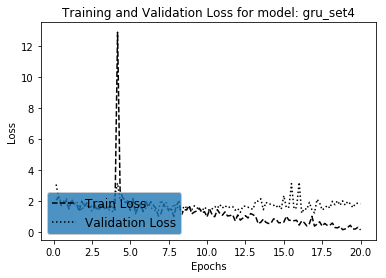

In [63]:
fig, ax = plt.subplots()
ax.plot(x, train_loss, 'k--', label='Train Loss')
ax.plot(x, val_loss, 'k:', label='Validation Loss')

legend = ax.legend(loc='lower left', shadow=False, fontsize='large')
legend.get_frame().set_facecolor('C0')
plt.title('Training and Validation Loss for model: '+model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [68]:
batch_size = X_val.shape[0]
seq_length = X_val.shape[1]
embed_size = X_val.shape[2]

pred_net = RNN(num_classes, batch_size, seq_length, embed_size, cell_type=cell_type,
                 rnn_size=rnn_size, num_layers=2, learning_rate=lr, train_keep_prob=1)
preds = pred_net.predict('./model/'+model_name, X_val)
preds = preds_to_scores(preds, min_score)

INFO:tensorflow:Restoring parameters from ./model/gru_set4
Running network predictions


In [67]:
from src.preprocess import quadratic_weighted_kappa
k = quadratic_weighted_kappa(preds[0], y_val)

print('The quadratic weighted kappa score for set {} using {} is : {}'\
     .format(set, model_name, k))

The quadratic weighted kappa score for set 1 using gru_set4 is : 0.376844494892168
